In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Initializing

In [2]:
df = pd.read_csv('subscribers.csv')

In [3]:
df.drop(['Unnamed: 0', 'subid', 'cancel_date', 'last_payment', 'next_payment', 'num_weekly_services_utilized', 'num_ideal_streaming_services'], axis = 1, inplace = True)

In [ ]:
df.attribution_survey.value_counts().index

[Index(['facebook', 'tv', 'referral', 'search', 'pinterest', 'other',
        'public_radio', 'social_organic', 'youtube', 'podcast', 'affiliate',
        'ott', 'sirius xm', 'facebook_organic', 'direct_mail', 'amfm_radio'],
       dtype='object')]

# Data Overview

In [ ]:
df.isna().sum()

In [4]:
df.dropna(axis = 0, subset = ['age'], inplace = True)

In [ ]:
df.isna().sum()

In [5]:
df.dropna(axis = 0, subset = ['male_TF', 'intended_use', 'weekly_consumption_hour'], inplace = True)

In [ ]:
df.isna().sum()

In [ ]:
df.age.describe()

In [ ]:
df.weekly_consumption_hour.describe()

In [ ]:
df.months_per_bill_period.value_counts()

In [ ]:
df.trial_completed.value_counts()

In [ ]:
df[df.current_sub_TF == True].isna().sum()

In [ ]:
df[df.current_sub_TF == False].isna().sum()

In [ ]:
#df.num_ideal_streaming_services.describe()

In [ ]:
#df.num_weekly_services_utilized.describe()

In [ ]:
#df[df.current_sub_TF == True].num_ideal_streaming_services.describe()

In [ ]:
#df[df.current_sub_TF == False].num_ideal_streaming_services.describe()

In [ ]:
df.country.value_counts()

In [ ]:
df.discount_price.value_counts()

In [ ]:
df.monthly_price.value_counts()

In [ ]:
df.attribution_technical.value_counts()

# Create Null Counts

In [6]:
number_of_nulls = [row.isna().sum() for i, row in df.iterrows()]

In [7]:
df['null_count'] = number_of_nulls

# Processing

In [ ]:
df.columns

Index(['package_type', 'preferred_genre', 'intended_use',
       'weekly_consumption_hour', 'age', 'male_TF', 'country',
       'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'trial_end_date',
       'initial_credit_card_declined', 'join_fee', 'language', 'payment_type',
       'num_trial_days', 'current_sub_TF', 'payment_period',
       'trial_completed'],
      dtype='object')

In [8]:
df.current_sub_TF = pd.get_dummies(df.current_sub_TF)

In [9]:
df.drop(df[df.age > 100].index, inplace = True)

In [ ]:
y_col_name = 'current_sub_TF'

In [10]:
x_cat_name = ['intended_use', 'male_TF', 'attribution_technical', 'package_type', 'preferred_genre']

In [11]:
dummy_df = pd.get_dummies(df[x_cat_name])

In [ ]:
dummy_df

# Subset for Churn Modeling

In [ ]:
df_churn = df.merge(dummy_df, left_index = True, right_index = True)

In [ ]:
df_churn.drop(x_cat_name, axis = 1, inplace = True)

In [ ]:
scaler = StandardScaler()
df_churn.age = scaler.fit_transform(df_churn.age.values.reshape(-1,1))
df_churn.weekly_consumption_hour = scaler.fit_transform(df_churn.weekly_consumption_hour.values.reshape(-1,1))
df_churn.null_count = scaler.fit_transform(df_churn.null_count.values.reshape(-1,1))

In [ ]:
df_churn.drop(df_churn[(df_churn.weekly_consumption_hour > 3) | (df_churn.weekly_consumption_hour < -3)].index, inplace = True)
df_churn.drop(df_churn[(df_churn.age > 3) | (df_churn.age < -3)].index, inplace = True)
df_churn.drop(df_churn[(df_churn.null_count > 3) | (df_churn.null_count < -3)].index, inplace = True)

In [ ]:
df_churn['trial_completed'] = pd.get_dummies(df_churn.trial_completed)

In [ ]:
df_churn.drop(['country', 'attribution_survey', 'op_sys', 'months_per_bill_period', 'plan_type', 'monthly_price', 'discount_price', 'account_creation_date', 'trial_end_date', 'initial_credit_card_declined', 'join_fee', 'language', 'payment_type', 'num_trial_days'], axis = 1, inplace = True)

In [ ]:
df_churn

,weekly_consumption_hour,age,current_sub_TF,payment_period,trial_completed,null_count,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_True,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_economy,package_type_enhanced,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional
1,-1.014623,1.708236,1,1,0,1.012424,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.606959,-1.511495,0,0,0,-0.144575,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-1.597197,-1.153748,0,0,0,-0.144575,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,-1.014623,-1.296847,1,2,0,-0.144575,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-1.597197,1.708236,1,1,0,-0.144575,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227622,-0.723336,-0.223603,1,1,0,-0.144575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
227623,0.150524,-0.581351,1,1,0,-0.144575,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
227624,-0.140763,0.205695,1,1,0,-1.301574,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
227625,0.733098,-0.080504,1,1,0,-0.144575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.current_sub_TF.value_counts()

In [ ]:
df_churn.package_type.value_counts()

base        86070
enhanced    53129
economy     15839
Name: package_type, dtype: int64

In [ ]:
df.preferred_genre.value_counts()

In [ ]:
df_train_churn, df_test_churn = model_selection.train_test_split(df_churn, test_size = 0.3, stratify = df_churn.current_sub_TF, random_state = 23)

In [ ]:
lpm_model = sm.OLS(endog = df_train_churn[y_col_name], exog = df_train_churn.drop(y_col_name, axis = 1))
lpm_results = lpm_model.fit()
print(lpm_results.summary())

                                 OLS Regression Results                                
Dep. Variable:         current_sub_TF   R-squared (uncentered):                 -57.422
Model:                            OLS   Adj. R-squared (uncentered):            -57.445
Method:                 Least Squares   F-statistic:                             -2535.
Date:                Fri, 10 Dec 2021   Prob (F-statistic):                        1.00
Time:                        01:04:38   Log-Likelihood:                         -23467.
No. Observations:              128984   AIC:                                  4.703e+04
Df Residuals:                  128934   BIC:                                  4.752e+04
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------

In [ ]:
lpm_pred = lpm_results.predict(df_test_churn.drop('current_sub_TF', axis = 1))

In [ ]:
lpm_pred[lpm_pred >= 0.5] = 1
lpm_pred[lpm_pred < 0.5] = 0

In [ ]:
fp1, tp1, threshold = roc_curve(df_test_churn.current_sub_TF, lpm_pred)

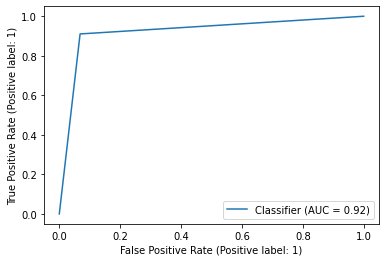

In [ ]:
y_test = df_test_churn.current_sub_TF
RocCurveDisplay.from_predictions(y_test, lpm_pred)
plt.show()

In [ ]:
roc_auc_score(y_test, lpm_pred)

0.9210857807369633

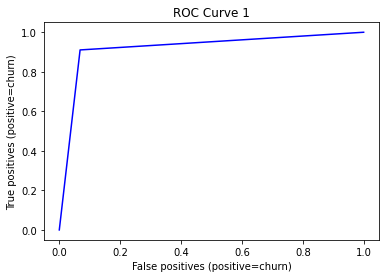

In [ ]:
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(fp1, tp1, 'b-')
plt.title('ROC Curve 1')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.show()

In [ ]:
df_train_churn.drop('male_TF_True', axis = 1, inplace = True)
df_test_churn.drop('male_TF_True', axis = 1, inplace = True)

In [ ]:
lpm_model2 = sm.OLS(endog = df_train_churn[y_col_name], exog = df_train_churn.drop(y_col_name, axis = 1))
lpm_results2 = lpm_model2.fit()
print(lpm_results2.summary())

                                 OLS Regression Results                                
Dep. Variable:         current_sub_TF   R-squared (uncentered):                 -57.423
Model:                            OLS   Adj. R-squared (uncentered):            -57.445
Method:                 Least Squares   F-statistic:                             -2586.
Date:                Fri, 10 Dec 2021   Prob (F-statistic):                        1.00
Time:                        01:04:53   Log-Likelihood:                         -23468.
No. Observations:              128984   AIC:                                  4.703e+04
Df Residuals:                  128935   BIC:                                  4.751e+04
Df Model:                          49                                                  
Covariance Type:            nonrobust                                                  
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------

In [ ]:
lpm_pred2 = lpm_results2.predict(df_test_churn.drop('current_sub_TF', axis = 1))

In [ ]:
lpm_pred2[lpm_pred2 >= 0.5] = 1
lpm_pred2[lpm_pred2 < 0.5] = 0

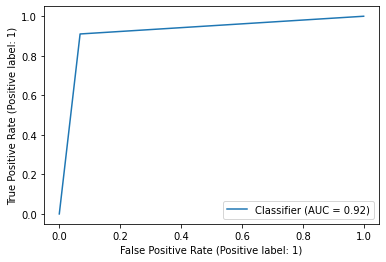

In [ ]:
y_test = df_test_churn.current_sub_TF
RocCurveDisplay.from_predictions(y_test, lpm_pred2)
plt.show()

In [ ]:
roc_auc_score(y_test, lpm_pred2)

0.9210043209780843

In [ ]:
lpm_model2 = sm.OLS(endog = df_train_churn[y_col_name], exog = df_train_churn.drop(y_col_name, axis = 1))
lpm_results2 = lpm_model2.fit()
lpm_pred2 = lpm_results2.predict(df_test_churn.drop('current_sub_TF', axis = 1))

In [ ]:
lpm_pred2

119482    0.470298
202659    0.729335
92536     0.772217
216064    0.823910
3622      0.625142
            ...   
179783    0.013204
34919     0.778130
21297     0.101960
26401    -0.038266
64612     0.785186
Length: 55280, dtype: float64

In [ ]:
logit_model = sm.Logit(endog = df_train_churn[y_col_name], exog = df_train_churn.drop(y_col_name, axis = 1))
logit_result = logit_model.fit()
logit_pred = logit_result.predict(df_test_churn.drop('current_sub_TF', axis = 1))

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
logit_pred[logit_pred >= 0.5] = 1
logit_pred[logit_pred < 0.5] = 0

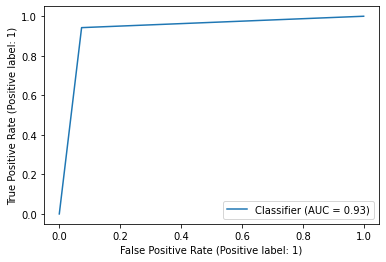

In [ ]:
y_test = df_test_churn.current_sub_TF
RocCurveDisplay.from_predictions(y_test, logit_pred)
plt.show()

In [ ]:
logit_model = sm.Logit(endog = df_train_churn[y_col_name], exog = df_train_churn.drop(y_col_name, axis = 1))
logit_result = logit_model.fit()
logit_pred = logit_result.predict(df_test_churn.drop('current_sub_TF', axis = 1))

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
df_churn_prob = pd.DataFrame(1 - lpm_pred2, index = df_test_churn.index, columns = ['lpm_prob'])
df_churn_prob['current_churn_TF'] = df_test_churn.current_sub_TF
df_churn_prob.current_churn_TF.replace({0:1, 1:0}, inplace = True)
df_churn_prob['random_draw'] = np.random.random(df_churn_prob.shape[0])
df_churn_prob['logit_prob'] = 1 - logit_pred

In [ ]:
df_churn_prob

,lpm_prob,current_churn_TF,random_draw,logit_prob
119482,0.529840,0,0.044400,0.009173
202659,0.270975,0,0.894147,0.058542
92536,0.227996,0,0.771440,0.030921
216064,0.175990,0,0.313278,0.000376
3622,0.375503,0,0.068344,0.195080
...,...,...,...,...
179783,0.987363,1,0.244321,0.998837
34919,0.222110,0,0.066330,0.052618
21297,0.897728,1,0.823152,0.972202
26401,1.037495,1,0.424302,0.995492


In [ ]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['current_churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['current_churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['current_churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draw'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['lpm_prob'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['logit_prob'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price
    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1
    return df_f, df_impact

In [ ]:
acceptance_rate_nonchurn = 1
threshold = 0.5
base_price = 4.7343
discount_amount = 0.3
acceptance_rate_churn = discount_amount
cases = ['no_offer', 'lpm_offer', 'logit_offer']

In [ ]:
df_offer, df_impact = apply_offers(df_churn_prob, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

In [ ]:
df_offer

,lpm_prob,current_churn_TF,random_draw,logit_prob,price_no_offer,accept_offer_prob,would_accept_offer_rand_draw,make_offer_lpm,accept_offer_lpm,price_lpm_offer,make_offer_logit,accept_offer_logit,price_logit_offer
119482,0.529840,0,0.044400,0.009173,4.7343,1.0,True,True,True,3.31401,False,False,4.73430
202659,0.270975,0,0.894147,0.058542,4.7343,1.0,True,False,False,4.73430,False,False,4.73430
92536,0.227996,0,0.771440,0.030921,4.7343,1.0,True,False,False,4.73430,False,False,4.73430
216064,0.175990,0,0.313278,0.000376,4.7343,1.0,True,False,False,4.73430,False,False,4.73430
3622,0.375503,0,0.068344,0.195080,4.7343,1.0,True,False,False,4.73430,False,False,4.73430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179783,0.987363,1,0.244321,0.998837,0.0000,0.3,True,True,True,3.31401,True,True,3.31401
34919,0.222110,0,0.066330,0.052618,4.7343,1.0,True,False,False,4.73430,False,False,4.73430
21297,0.897728,1,0.823152,0.972202,0.0000,0.3,False,True,False,0.00000,True,False,0.00000
26401,1.037495,1,0.424302,0.995492,0.0000,0.3,False,True,False,0.00000,True,False,0.00000


In [ ]:
df_impact

,subs,revenue,lift_from_no_offer
no_offer,30690,145296,0
lpm_offer,37515,164005,0.128768
logit_offer,37468,165247,0.137315


In [ ]:
discount_amount = 0.3
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_offer, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)
    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

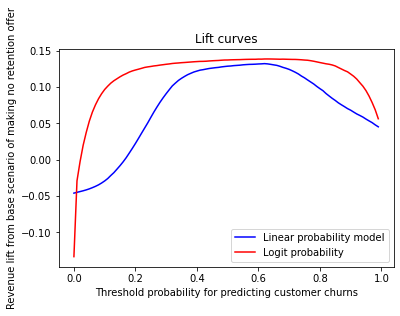

In [ ]:
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])
plt.savefig('threshold sensitivity 03.jpeg')

In [ ]:
threshold = 0.8
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_offer, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)
    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

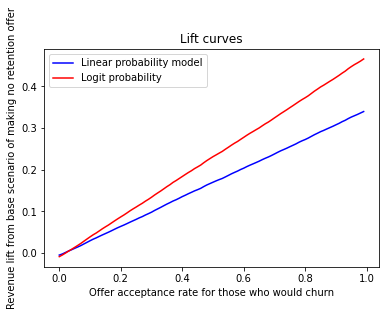

In [ ]:
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [ ]:
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_offer, threshold, base_price, t_discount_amount, cases, t_discount_amount, acceptance_rate_nonchurn)
    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

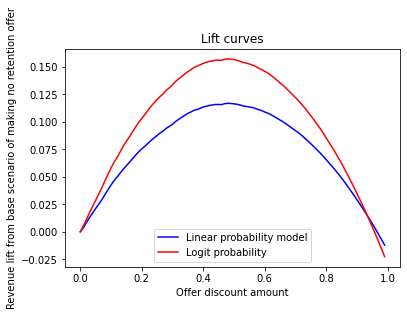

In [ ]:
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])
plt.savefig('discount amount sensitivity dependent')

# Customer segmentation

In [12]:
df_segmentation = df.merge(dummy_df, left_index = True, right_index = True)
df_segmentation.drop(x_cat_name, axis = 1, inplace = True)

In [ ]:
df_segmentation

,weekly_consumption_hour,age,attribution_survey,op_sys,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_True,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_economy,package_type_enhanced,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional
1,22.951579,70.0,facebook,NaN,0.3303,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36.001186,25.0,facebook,iOS,0.1101,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,20.051667,30.0,tv,Android,0.0367,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,22.951579,28.0,youtube,iOS,0.0367,1,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,20.051667,70.0,tv,NaN,0.3303,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227622,24.401536,43.0,pinterest,iOS,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
227623,28.751405,38.0,facebook_organic,iOS,0.3303,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
227624,27.301448,49.0,referral,iOS,0.3303,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
227625,31.651317,45.0,facebook,iOS,0.0367,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_segmentation.drop(['country', 'monthly_price', 'discount_price', 'plan_type', 'months_per_bill_period', 'account_creation_date', 'trial_end_date', 'initial_credit_card_declined', 'language', 'num_trial_days', 'payment_type'], axis = 1, inplace = True)

In [14]:
df_segmentation['trial_completed'] = pd.get_dummies(df_segmentation.trial_completed)

In [15]:
dummy_name = ['attribution_survey', 'op_sys']

In [16]:
dummy_df = pd.get_dummies(df_segmentation[dummy_name])

In [ ]:
df_segmentation.attribution_survey.value_counts()

In [ ]:
df_segmentation

# Segment by demographic (age and gender)

In [17]:
df_segmentation_age = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_age.drop(dummy_name, axis = 1, inplace = True)

In [18]:
scaler = StandardScaler()
df_segmentation_age.age = scaler.fit_transform(df_segmentation_age.age.values.reshape(-1,1))

In [19]:
df_segmentation_age

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
1,22.951579,1.708236,0.3303,0,1,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36.001186,-1.511495,0.1101,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,20.051667,-1.153748,0.0367,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,22.951579,-1.296847,0.0367,0,2,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,20.051667,1.708236,0.3303,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227622,24.401536,-0.223603,0.0000,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
227623,28.751405,-0.581351,0.3303,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
227624,27.301448,0.205695,0.3303,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
227625,31.651317,-0.080504,0.0367,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


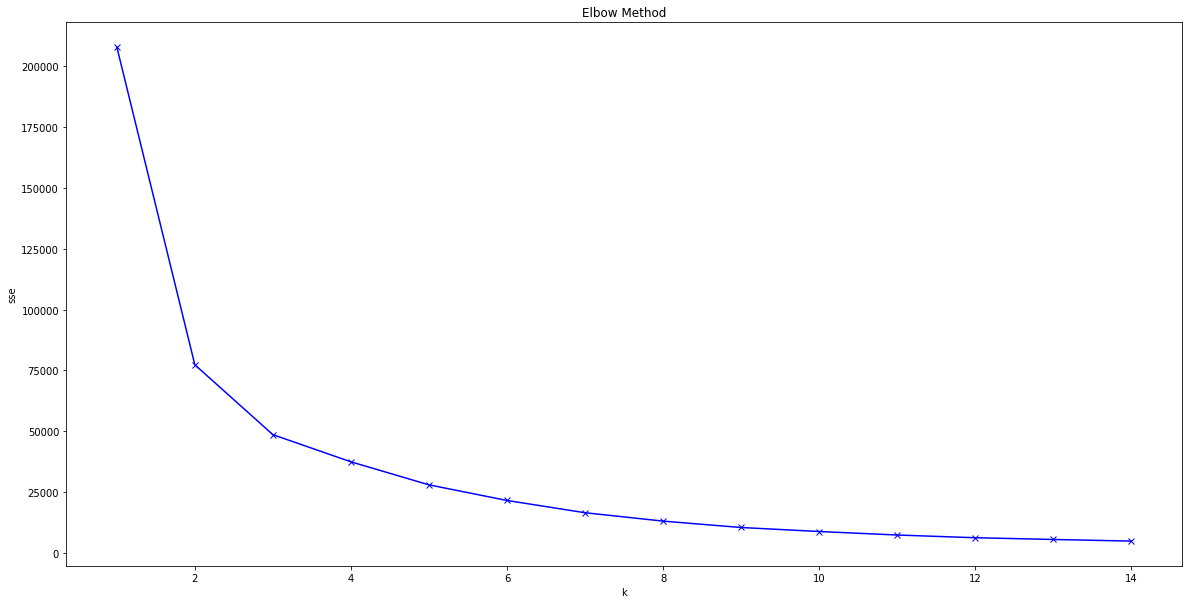

In [20]:
sse = []
for k in range(1,15):
  km = KMeans(n_clusters = k)
  km = km.fit(df_segmentation_age[['age', 'male_TF_True']])
  sse.append(km.inertia_)
plt.figure(figsize = (20, 10))
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_age[['age','male_TF_True']])
centroids = kmeans.cluster_centers_
clusters = kmeans.labels_

In [22]:
centroids

array([[ 0.02790065,  0.12684407],
       [-1.14094212,  0.1250744 ],
       [ 1.20367033,  0.13603879]])

In [ ]:
#kmeans = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_age['age'].values.reshape(-1,1))
#centroids = kmeans.cluster_centers_
#clusters = kmeans.labels_

In [ ]:
#centroids

array([[ 0.06354215],
       [-1.14094212],
       [ 1.25267213]])

In [23]:
df_segmentation_age['clusters'] = clusters
df_segmentation_age.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,28.174227,0.027901,0.113956,0.453011,0.771158,0.128510,1.121127,0.353469,0.030112,0.074412,0.076643,0.032540,0.301588,0.131235,0.873156,0.126844,0.045528,0.000240,0.004899,0.001892,0.009727,0.085650,0.000042,0.000198,0.000889,0.012720,0.006903,0.113348,0.037411,0.349629,0.015388,0.050738,0.000014,0.006677,0.087005,0.010207,0.000508,0.024550,0.000113,0.000056,0.002555,0.000353,0.021755,0.000438,0.105979,0.000028,0.000028,0.001383,0.003148,0.450780,0.079000,0.284196,0.513433,0.198165,0.030973,0.019383,0.051641,0.009388,0.001426,0.002315,0.529470,0.004292,0.031637,0.005774,0.033218,0.010193,0.027698,0.090661,0.035166,0.006310,0.021684,0.177172,0.011012,0.328496,0.620908
1,28.149307,-1.140942,0.084142,0.318018,0.965793,0.083906,1.136681,0.346918,0.025031,0.070283,0.063306,0.019840,0.342620,0.132002,0.874926,0.125074,0.055932,0.000265,0.003026,0.000843,0.003224,0.065273,0.000033,0.000066,0.000628,0.008978,0.003340,0.106508,0.030487,0.272981,0.020154,0.067820,0.000281,0.006283,0.094058,0.010052,0.001505,0.038258,0.000265,0.000083,0.011540,0.000562,0.024370,0.000645,0.162919,0.000000,0.000017,0.001918,0.007688,0.421500,0.052559,0.363997,0.566662,0.167929,0.023147,0.019823,0.060198,0.008366,0.001257,0.001554,0.497173,0.003274,0.039002,0.013905,0.058908,0.032091,0.020038,0.091363,0.057156,0.002579,0.022088,0.121206,0.028222,0.327921,0.630448
2,27.623384,1.203670,0.148609,0.579943,0.559598,0.169276,1.117095,0.418765,0.025391,0.060136,0.082762,0.055091,0.252559,0.105297,0.863961,0.136039,0.036452,0.000126,0.010594,0.003250,0.022320,0.100144,0.000000,0.000467,0.000611,0.018872,0.011744,0.113503,0.031298,0.373083,0.011582,0.031173,0.000054,0.004040,0.094739,0.007398,0.000503,0.026989,0.000108,0.000018,0.000664,0.000700,0.016807,0.000233,0.077554,0.000036,0.000036,0.001401,0.003502,0.506913,0.124996,0.193949,0.469671,0.271557,0.043401,0.

# Segment by consumption time

In [35]:
df_segmentation_time = df_segmentation.merge(dummy_df, left_index=True, right_index=True)
df_segmentation_time.drop(dummy_name, axis = 1, inplace = True)
df_segmentation_time.weekly_consumption_hour = scaler.fit_transform(df_segmentation_time.weekly_consumption_hour.values.reshape(-1,1))

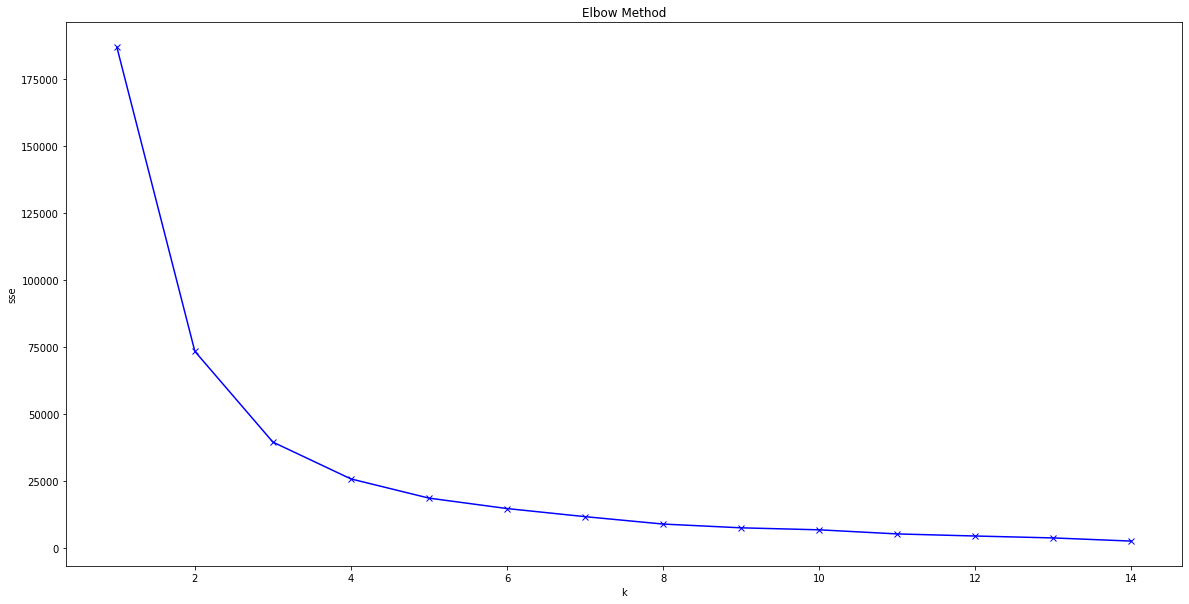

In [36]:
sse = []
for k in range(1,15):
  km = KMeans(n_clusters = k)
  km = km.fit(df_segmentation_time['weekly_consumption_hour'].values.reshape(-1,1))
  sse.append(km.inertia_)
plt.figure(figsize = (20, 10))
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method')
plt.show()

In [ ]:
kmeans2 = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_time['weekly_consumption_hour'].values.reshape(-1,1))
centroids2 = kmeans2.cluster_centers_
clusters2 = kmeans2.labels_

In [ ]:
centroids2

array([[ 0.0670097 ],
       [-1.08215191],
       [ 1.61873782]])

In [ ]:
df_segmentation_time['clusters'] = clusters2
df_segmentation_time.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_True,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_economy,package_type_enhanced,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.067010,45.939480,0.111575,0.572705,0.812163,0.119296,1.138351,0.028012,0.070606,0.076722,0.035003,0.297527,0.123809,0.054796,0.000256,0.005673,0.002025,0.010737,0.082641,0.000039,0.000275,0.000718,0.013116,0.006971,0.111381,0.034521,0.337466,0.016420,0.049899,0.000069,0.006145,0.086957,0.009242,0.000796,0.031591,0.000147,0.000059,0.004729,0.000452,0.020451,0.000393,0.114095,0.000010,0.000039,0.001642,0.004769,0.082297,0.280517,0.200442,0.031896,0.020274,0.044727,0.001613,0.002193,0.507114,0.003864,0.032929,0.007374,0.042141,0.014660,0.028416,0.090713,0.040165,0.005113,0.019842,0.175134,0.015722,0.618534
1,-1.082152,46.939342,0.110915,0.476971,0.650674,0.151596,1.167477,0.028165,0.068258,0.076180,0.040951,0.298738,0.124084,0.005070,0.000168,0.006953,0.001752,0.012097,0.080467,0.000019,0.000168,0.000764,0.014632,0.006580,0.110757,0.032936,0.356391,0.015620,0.043710,0.000186,0.005182,0.080430,0.008817,0.000727,0.034446,0.000224,0.000037,0.003709,0.000503,0.019944,0.000578,0.112938,0.000019,0.000000,0.001510,0.005611,0.082089,0.270480,0.203005,0.027699,0.018080,0.037130,0.001193,0.001528,0.513281,0.004213,0.032992,0.006710,0.044083,0.011799,0.023095,0.083152,0.041734,0.003933,0.019012,0.184570,0.016869,0.593506
2,1.618738,45.341779,0.130758,0.617659,0.843311,0.105481,1.009856,0.022145,0.064066,0.062455,0.025778,0.311610,0.123045,0.577508,0.000158,0.005370,0.002085,0.012194,0.090665,0.000000,0.000221,0.000663,0.011878,0.008940,0.111262,0.030295,0.272058,0.014089,0.063560,0.000126,0.005528,0.125383,0.010425,0.001106,0.015637,0.000095,0.000063,0.007455,0.000790,0.025304,0.000379,0.126899,0.000063,0.000032,0.001390,0.003064,0.093571,0.312968,0.253988,0.040468,0.023124,0.057716,0.002843,0.002117,0.426662,0.003665,0.038888,0.009446,0.020250,0.023503,0.052630,0.100964,0.052030,0.010741,0.020250,0.206318,0.015353,0.603380


# Segment by intended use

In [24]:
df_segmentation_use = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_use.drop(dummy_name, axis = 1, inplace = True)
intended_uses = ['intended_use_' + use for use in df.intended_use.value_counts().index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWar

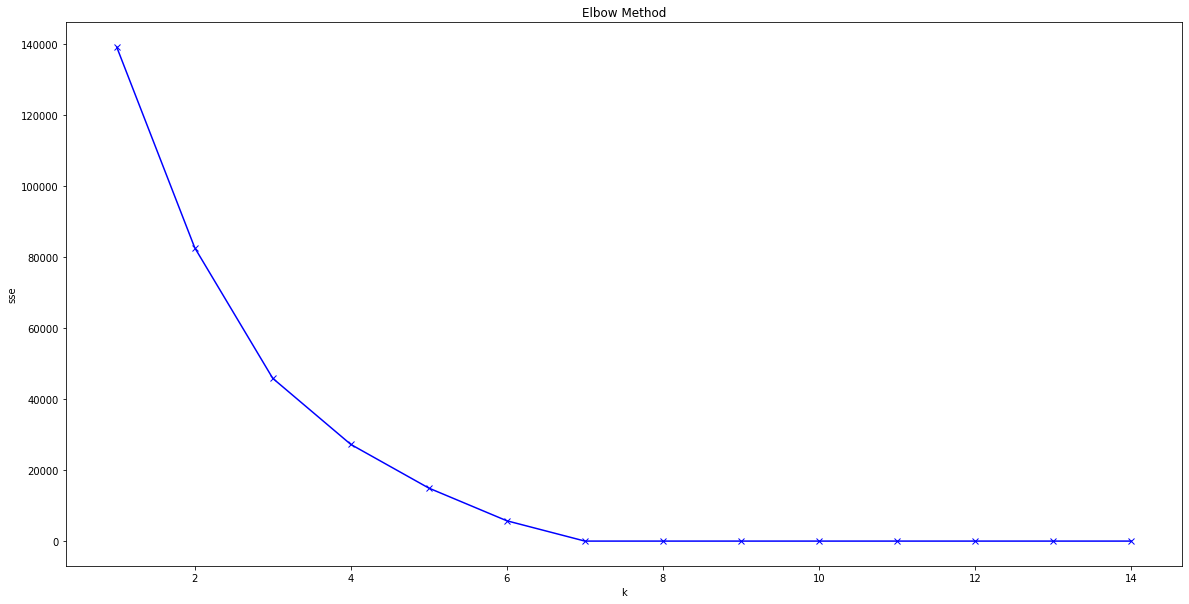

In [37]:
sse = []
for k in range(1,15):
  km = KMeans(n_clusters = k)
  km = km.fit(df_segmentation_use[intended_uses])
  sse.append(km.inertia_)
plt.figure(figsize = (20, 10))
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method')
plt.show()

In [27]:
kmeans3 = KMeans(n_clusters = 4, random_state = 6).fit(df_segmentation_use[intended_uses])
centroids3 = kmeans3.cluster_centers_
clusters3 = kmeans3.labels_

In [28]:
df_segmentation_use['clusters'] = clusters3
df_segmentation_use.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.807505,46.407650,0.076120,0.579687,0.717456,0.153944,1.769296,0.0,0.082271,0.20923,0.225421,0.10685,0.0,0.376227,0.896190,0.103810,0.047646,0.000098,0.004991,0.001479,0.009266,0.080516,0.000016,0.000390,0.000406,0.008502,0.005885,0.115791,0.042834,0.365401,0.014321,0.048459,0.000114,0.007429,0.088611,0.008226,0.000341,0.032154,0.000130,0.000016,0.002942,0.000358,0.019751,0.001317,0.088952,0.000033,0.000081,0.000797,0.002747,0.254210,0.047792,0.166932,0.293924,0.103745,0.023392,0.016370,0.030204,0.008583,0.000845,0.001463,0.534609,0.001918,0.036169,0.003901,0.040916,0.009233,0.026725,0.076793,0.033243,0.003056,0.017426,0.192308,0.010615,0.326712,0.603355
1,28.060948,44.402613,0.123817,0.597407,0.530195,0.177468,0.810778,0.0,0.000000,0.00000,0.000000,0.00000,1.0,0.000000,0.861035,0.138965,0.043009,0.000196,0.006999,0.001941,0.010739,0.079767,0.000053,0.000178,0.000712,0.016153,0.007284,0.103097,0.029563,0.317590,0.018237,0.051468,0.000142,0.005165,0.088226,0.009225,0.000890,0.028673,0.000142,0.000071,0.005645,0.000695,0.021763,0.000018,0.145696,0.000000,0.000000,0.001638,0.005022,0.514274,0.084576,0.401133,0.633649,0.254332,0.032181,0.022386,0.057434,0.010222,0.001763,0.002155,0.490944,0.004862,0.034229,0.008014,0.040088,0.017613,0.025859,0.096169,0.055867,0.005895,0.022350,0.162419,0.018824,0.312212,0.633916
2,28.127161,47.269381,0.141362,0.207897,1.013787,0.060137,0.807750,1.0,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.856696,0.143304,0.047475,0.000332,0.006057,0.002394,0.013758,0.088835,0.000014,0.000144,0.001009,0.015359,0.008278,0.113640,0.028006,0.313562,0.015128,0.051354,0.000087,0.004773,0.096954,0.010369,0.001211,0.028381,0.000202,0.000072,0.006028,0.000534,0.021834,0.000014,0.115760,0.000029,0.000000,0.002178,0.006230,0.593291,0.116048,0.290661,0.622105,0.269014,0.039875,0.021632,0.047374,0.011479,0.002408,

# Segment by preferred genre

In [25]:
df_segmentation_genre = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_genre.drop(dummy_name, axis = 1, inplace = True)
preferred_genre = ['preferred_genre_' + genre for genre in df.preferred_genre.value_counts().index]

In [ ]:
sse = []
for k in range(1,10):
  km = KMeans(n_clusters = k)
  km = km.fit(df_segmentation_genre[preferred_genre])
  sse.append(km.inertia_)
plt.figure(figsize = (20, 10))
plt.plot(range(1,10), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.


In [29]:
kmeans4 = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_genre[preferred_genre])
centroids4 = kmeans4.cluster_centers_
clusters4 = kmeans4.labels_

In [30]:
df_segmentation_genre['clusters'] = clusters4
df_segmentation_genre.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.798158,44.994426,0.128462,0.260943,0.969907,0.074371,0.832416,0.445645,0.000413,0.000940,0.001105,0.032614,0.367566,0.151716,0.885402,0.114598,0.045569,0.000289,0.006436,0.001911,0.011767,0.081798,0.000021,0.000186,0.000909,0.016002,0.007996,0.106819,0.028719,0.319745,0.016126,0.050889,0.000145,0.005093,0.090032,0.010155,0.001064,0.031529,0.000145,0.000093,0.005641,0.000682,0.020331,0.000010,0.131902,0.000021,0.000000,0.001922,0.006054,0.542041,0.085238,0.372659,1.0,0.0,0.000000,0.000000,0.000000,0.011136,0.001767,0.002438,0.480294,0.004515,0.033327,0.009866,0.042180,0.018440,0.032035,0.090022,0.048544,0.007190,0.021684,0.174547,0.019246,0.320076,0.619944
1,28.398164,49.006413,0.144821,0.529516,0.593636,0.157438,0.783758,0.474451,0.000254,0.000890,0.000738,0.032047,0.363227,0.128392,0.822850,0.177150,0.048961,0.000178,0.007223,0.002518,0.013404,0.088918,0.000051,0.000102,0.000865,0.016965,0.009182,0.110461,0.028690,0.313503,0.016634,0.049902,0.000102,0.004273,0.096549,0.008724,0.000890,0.026401,0.000280,0.000000,0.005239,0.000636,0.021594,0.000051,0.120965,0.000025,0.000000,0.001908,0.004807,0.592822,0.143805,0.263372,0.0,1.0,0.000000,0.000000,0.000000,0.011725,0.002772,0.001780,0.459064,0.005214,0.036905,0.007732,0.032327,0.015235,0.034158,0.099957,0.044892,0.007020,0.018542,0.202050,0.017066,0.345779,0.569906
2,28.084134,46.049889,0.065007,0.737685,0.530093,0.200735,1.944963,0.148350,0.098461,0.250427,0.269801,0.042363,0.123593,0.067003,0.880769,0.119231,0.045232,0.000098,0.004185,0.001611,0.009058,0.082094,0.000020,0.000432,0.000255,0.005482,0.004126,0.120036,0.045763,0.368951,0.014521,0.049987,0.000059,0.008194,0.090720,0.008194,0.000334,0.028806,0.000098,0.000020,0.003222,0.000138,0.022282,0.001572,0.081662,0.000020,0.000098,0.000609,0.002122,0.194093,0.035977,0.128112,0.0,0.0,0.118111,0.073959,0.164423,0.007054,0.0

# Segment by attribution survey

In [31]:
df_segmentation_attribution_survey = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_attribution_survey.drop(dummy_name, axis = 1, inplace = True)
attribution_survey = ['attribution_survey_' + attribution for attribution in df.attribution_survey.value_counts().index]

In [32]:
kmeans5 = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_attribution_survey[attribution_survey])
centroids5 = kmeans5.cluster_centers_
clusters5 = kmeans5.labels_

In [33]:
df_segmentation_attribution_survey['clusters'] = clusters5
df_segmentation_attribution_survey.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,28.343671,44.394364,0.118059,0.226503,1.081719,0.059423,0.910500,0.397074,0.017541,0.046438,0.049381,0.032505,0.323618,0.133444,0.839488,0.160512,0.069582,0.000366,0.008696,0.001812,0.010624,0.092959,0.000050,0.000316,0.001713,0.021548,0.008679,0.107673,0.031740,0.142689,0.007116,0.062931,0.000333,0.006451,0.093773,0.013600,0.001363,0.064860,0.000333,0.000083,0.014681,0.000798,0.053986,0.000765,0.168260,0.000017,0.000050,0.000582,0.011572,0.477197,0.093341,0.313376,0.555508,0.221531,0.031673,0.023593,0.051259,0.031557,0.005287,0.006185,0.0,0.01222,0.105578,0.023427,0.12124,0.047685,0.09635,0.280705,0.13253,0.017807,0.061169,0.0,0.049713,0.302436,0.636861
1,27.715163,45.618767,0.098192,0.533573,0.692169,0.147821,1.255045,0.347283,0.032693,0.082856,0.085846,0.035252,0.297639,0.118431,0.906337,0.093663,0.034421,0.000097,0.002915,0.001231,0.006381,0.054211,0.000011,0.000184,0.000238,0.008853,0.006046,0.113854,0.036526,0.524536,0.025502,0.031074,0.000011,0.004707,0.051264,0.006349,0.000086,0.011488,0.000076,0.000032,0.000259,0.000443,0.006262,0.000259,0.070828,0.000000,0.000011,0.000313,0.001533,0.443764,0.072631,0.277038,0.501970,0.194874,0.031570,0.019057,0.045358,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.331714,0.607672
2,28.178408,50.534501,0.153081,0.600934,0.439071,0.185137,1.149774,0.388232,0.028559,0.070200,0.086027,0.039509,0.266316,0.121156,0.830720,0.169280,0.036940,0.000263,0.009549,0.004176,0.026194,0.145423,0.000029,0.000234,0.000292,0.011067,0.007680,0.110118,0.027595,0.142795,0.004789,0.080859,0.000000,0.007417,0.196817,0.009841,0.001898,0.017258,0.000088,0.000058,0.000263,0.000263,0.003621,0.000380,0.146007,0.000088,0.000029,0.006658,0.001314,0.462929,0.099139,0.246489,0.493386,0.231975,0.034516,0.016937,0.031654,0.000000,0

# Segment by attribution tech

In [38]:
df_segmentation_attribution_tech = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_attribution_tech.drop(dummy_name, axis = 1, inplace = True)
attribution_technical = ['attribution_technical_' + attribution for attribution in df.attribution_technical.value_counts().index]

In [39]:
kmeans6 = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_attribution_tech[attribution_technical])
centroids6 = kmeans6.cluster_centers_
clusters6 = kmeans6.labels_

In [40]:
df_segmentation_attribution_tech['clusters'] = clusters6
df_segmentation_attribution_tech.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,28.223914,46.037526,0.102256,0.424149,0.788710,0.121636,1.062823,0.383171,0.025030,0.065776,0.075372,0.035962,0.291813,0.122876,0.849780,0.150220,0.083641,0.000387,0.010845,0.003544,0.020595,0.150976,0.000048,0.000426,0.001307,0.024159,0.013023,0.201327,0.060392,0.0,0.028603,0.091329,0.000203,0.010438,0.165848,0.016877,0.001501,0.053798,0.00029,0.000097,0.00887,0.000949,0.038257,0.000804,0.0,0.000039,0.000048,0.002827,0.00855,0.462455,0.092152,0.274413,0.513968,0.215299,0.032990,0.021099,0.045510,0.012355,0.002043,0.003157,0.362885,0.003612,0.038247,0.009838,0.059995,0.021612,0.041123,0.121782,0.036020,0.007204,0.016509,0.235827,0.024323,0.299201,0.633725
1,27.563850,47.872547,0.122560,0.518629,0.719196,0.142312,1.296919,0.350388,0.036049,0.085442,0.087118,0.034921,0.287379,0.118703,0.913350,0.086650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.449753,0.073726,0.262449,0.498775,0.198633,0.030909,0.017678,0.039176,0.006478,0.000693,0.000403,0.782899,0.004319,0.020112,0.001934,0.006736,0.004544,0.013569,0.038708,0.009250,0.002788,0.025027,0.078802,0.002208,0.354546,0.575837
2,28.200114,41.541006,0.150898,0.352122,0.835839,0.102030,0.928736,0.370249,0.011024,0.035793,0.031227,0.031919,0.377352,0.142435,0.850784,0.149216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.460609,0.075830,0.383856,0.588930,0.219373,0.031642,0.022509,0.057057,0.010148,0.002952,0.0

# Segment by package type

In [41]:
df_segmentation_package = df_segmentation.merge(dummy_df, left_index = True, right_index = True)
df_segmentation_package.drop(dummy_name, axis = 1, inplace = True)
package_type = ['package_type_' + package for package in df.package_type.value_counts().index]

In [42]:
kmeans7 = KMeans(n_clusters = 3, random_state = 6).fit(df_segmentation_package[package_type])
centroids7 = kmeans7.cluster_centers_
clusters7 = kmeans7.labels_

In [43]:
df_segmentation_package['clusters'] = clusters7
df_segmentation_package.groupby('clusters').mean()

,weekly_consumption_hour,age,join_fee,current_sub_TF,payment_period,trial_completed,null_count,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_False,male_TF_True,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,package_type_base,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,attribution_survey_affiliate,attribution_survey_amfm_radio,attribution_survey_direct_mail,attribution_survey_facebook,attribution_survey_facebook_organic,attribution_survey_other,attribution_survey_ott,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_Android,op_sys_iOS
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.893110,47.221040,0.137334,0.370731,0.818493,0.108412,0.815901,0.480299,0.000537,0.001331,0.001448,0.035223,0.337132,0.144031,0.874018,0.125982,0.042624,0.000304,0.006678,0.002358,0.013227,0.085401,0.000035,0.000187,0.000992,0.016496,0.008674,0.108365,0.030856,0.325830,0.016111,0.051637,0.000117,0.005008,0.091530,0.010285,0.001004,0.030133,0.000187,0.000082,0.005522,0.000549,0.021470,0.000023,0.116584,0.000023,0.000000,0.002020,0.005686,1.0,0.000000,0.0,0.612562,0.272115,0.040476,0.025147,0.048976,0.010963,0.002218,0.002288,0.479844,0.004436,0.032888,0.009001,0.039624,0.017314,0.034464,0.092371,0.041352,0.006981,0.020221,0.185080,0.017932,0.339455,0.594501
1,28.258400,42.573400,0.119074,0.271549,0.955371,0.076962,0.796196,0.380656,0.000434,0.000963,0.000888,0.031710,0.425399,0.159949,0.854782,0.145218,0.047348,0.000227,0.005723,0.001511,0.008726,0.078624,0.000000,0.000132,0.000661,0.014505,0.007592,0.103913,0.026875,0.307585,0.017357,0.050446,0.000151,0.004816,0.090976,0.009557,0.001152,0.029784,0.000132,0.000038,0.006100,0.000831,0.020454,0.000019,0.157173,0.000038,0.000000,0.001700,0.005855,0.0,0.000000,1.0,0.681291,0.195569,0.031597,0.022758,0.068407,0.010463,0.001549,0.001794,0.484608,0.005345,0.036375,0.010180,0.039926,0.019000,0.026875,0.093129,0.059492,0.006516,0.022059,0.159421,0.020794,0.302655,0.644802
2,27.914728,48.070962,0.069605,0.774449,0.485704,0.211627,2.031442,0.166240,0.103128,0.262488,0.282940,0.038776,0.098128,0.048300,0.883362,0.116638,0.051233,0.000041,0.005061,0.001735,0.010990,0.084989,0.000041,0.000434,0.000310,0.006487,0.004132,0.124117,0.044850,0.368942,0.013531,0.048300,0.000062,0.008139,0.092365,0.007354,0.000165,0.028881,0.000145,0.000021,0.002479,0.000145,0.021258,0.001653,0.069661,0.000000,0.000103,0.000599,0.001777,0.0,0.325084,0.0,0.170578,0.116804,0.017994,0.008367,0.011383,0.008367,0.0

# Attribution

In [96]:
df_attribution = pd.read_csv('subscribers.csv')
df_attribution.drop(['Unnamed: 0', 'subid', 'cancel_date', 'last_payment', 'next_payment', 'num_weekly_services_utilized', 'num_ideal_streaming_services'], axis = 1, inplace = True)
df_attribution.dropna(axis = 0, subset = ['attribution_survey'], inplace = True)

In [98]:
df_attribution['month'] = pd.DatetimeIndex(df_attribution.account_creation_date).month
df_attribution['year'] = pd.DatetimeIndex(df_attribution.account_creation_date).year

In [100]:
df_attribution.month.value_counts()

2     27843
11    26647
7     25316
3     25275
8     25271
12    25130
1     24583
10    22239
9     20056
6      2624
Name: month, dtype: int64

In [2]:
df_spend = pd.read_csv('channel_spend_graduate.csv')

In [106]:
df_spend['month'] = [str(date)[4:6] for date in df_spend.date.values]

In [162]:
df_spend_table = df_spend.pivot_table(values = 'spend_AED', columns = 'month', index = 'channel')
df_spend_table.loc['search'] = df_spend_table.loc['search'] + df_spend_table.loc['bing']
df_spend_table.drop('bing', axis = 0, inplace = True)

In [138]:
channels_last_touch = ['bing', 'display', 'facebook', 'search', 'youtube']

In [139]:
df_attribution_technical = df_attribution[df_attribution.attribution_technical.isin(channels_last_touch)]
df_attribution_technical = df_attribution_technical[['attribution_technical', 'month']]
df_attribution_technical.drop((df_attribution_technical[df_attribution_technical['month'] == 6].index | df_attribution_technical[df_attribution_technical['month'] == 3].index), axis = 0, inplace = True)

In [179]:
df_attribution_technical.attribution_technical.value_counts()

facebook    71788
search      21976
display      1246
bing          957
youtube       733
Name: attribution_technical, dtype: int64

In [155]:
df_attribution_technical_table = df_attribution_technical.pivot_table(index = 'attribution_technical', columns = 'month', aggfunc = 'size')
df_attribution_technical_table.loc['search'] = df_attribution_technical_table.loc['search'] + df_attribution_technical_table.loc['bing']
df_attribution_technical_table.drop('bing', axis = 0, inplace = True)

In [165]:
df_spend_table

month,01,02,07,08,09,10,11,12
channel,,,,,,,,
display,148,94,12,20,13,19,29,31
facebook,11000,14000,9000,13000,10500,17000,23000,16000
search,43100,47700,13400,19400,20000,25100,26300,38300
youtube,4360,2420,90,180,100,130,550,900


In [160]:
df_attribution_technical_table

month,1,2,7,8,9,10,11,12
attribution_technical,,,,,,,,
display,529,336,44,74,12,50,89,112
facebook,6277,7968,9959,9819,6105,9449,12949,9262
search,4218,4573,1436,1998,1925,2407,2600,3776
youtube,370,205,8,15,2,11,47,75


In [174]:
df_spend_table_s = df_spend_table
df_spend_table_s.drop('display', axis = 0, inplace = True)

In [176]:
channels_first_touch = ['bing', 'facebook', 'search', 'youtube']

In [177]:
df_attribution_survey = df_attribution[df_attribution.attribution_survey.isin(channels_first_touch)]
df_attribution_survey = df_attribution_survey[['attribution_survey', 'month']]
df_attribution_survey.drop((df_attribution_survey[df_attribution_survey.month == 6].index | df_attribution_survey[df_attribution_survey.month == 3].index), axis = 0, inplace = True)

In [181]:
df_attribution_survey_table = df_attribution_survey.pivot_table(index = 'attribution_survey', columns = 'month', aggfunc = 'size')

In [182]:
df_attribution_survey_table

month,1,2,7,8,9,10,11,12
attribution_survey,,,,,,,,
facebook,10157,11809,14451,15399,11702,13418,16930,13394
search,1151,1344,536,786,783,853,864,1032
youtube,725,546,85,264,209,274,312,245


facebook            119126
tv                   39904
referral             20882
search                8492
pinterest             7856
other                 6496
public_radio          6219
social_organic        3869
youtube               3108
podcast               2995
affiliate             1962
ott                   1443
sirius xm             1122
facebook_organic       765
direct_mail            408
amfm_radio             337
Name: attribution_survey, dtype: int64

[0.26274228284278534, 1.4193709748014756, 9.276341948310138, 9.572368421052632]

[0.9527726944579689, 27.47291568535092, 2.8088803088803087]